## visualize the uncertainty of a designer (class) using 5 samples

### Figure 3 in the paper
### How judged probability and uncertainty measures evolve with increasing observations provided to the model

In [2]:
from functools import cache
import IPython.display as ipd
import matplotlib.pyplot as plt
import PIL
import base64
import torchvision
from gpax.probing import probabilistic_probe
import torch
from pathlib import Path
import json
import itertools
import torchvision
import numpy as np

tensor_to_image = torchvision.transforms.ToPILImage()
@cache
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"

In [3]:
config = dict(
    use_gpu=True,
    dataset_root='F://datasets',
    dataset_name='fashion_brands_looks',
    set_img_num = 3,
    checkpoint_name = "resnet18",
    # checkpoint_name='imagenet',
    num_inducing = 100, #[100,200,300,400,500,600,700,800], #100
    latent_dim = 10, #[5,10,15,20,25,30,35,40,45,50], #10
    model_name='MultitaskDirichletGPModel', #MultitaskDirichletGPModel DirichletGPModel MeanFieldDecoupledModel MAPApproximateGP OrthDecoupledApproximateGP
    train_fc=True,
    num_epochs=50,
    learning_rate=0.01,
)

In [4]:
dataset_root = config['dataset_root']
dataset_name = config['dataset_name']
num_inducing = config['num_inducing']
latent_dim = config['latent_dim']
num_epochs = config['num_epochs']
model_name = config['model_name']
checkpoint_name = config['checkpoint_name']
use_gpu = config['use_gpu']
learning_rate = config['learning_rate']
train_fc = config['train_fc']
set_img_num = config['set_img_num']
img_root = dataset_root + "//"+dataset_name
print(img_root)


assert not use_gpu or torch.cuda.is_available(), 'GPU must be available if `use_gpu` is True'

F://datasets//fashion_brands_looks


## load dataset

In [6]:
# Load dataset
torch.manual_seed(0)
device = torch.device('cuda:0' if use_gpu else 'cpu')

embedding_path = Path('embeddings\\') / dataset_name / checkpoint_name
dataset_path = Path(dataset_root) / dataset_name
print("dataset path:")
print(dataset_path/'train.json')
print(dataset_path/'test.json')
print(dataset_path/'val.json')
print("embedding path:")
print(embedding_path)
train_metadata = json.loads((dataset_path / 'train.json').read_text())
test_metadata = json.loads((dataset_path / 'test.json').read_text())
# test_metadata = json.loads((dataset_path / 'brands_testing.json').read_text()) 
val_metadata = json.loads((dataset_path / 'val.json').read_text())

n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)

n_classes = 1 + max(meta['label'] for meta in itertools.chain(train_metadata, test_metadata, val_metadata))

train_classes = torch.as_tensor([meta['label'] for meta in train_metadata], dtype=torch.int)
test_classes = torch.as_tensor([meta['label'] for meta in test_metadata], dtype=torch.int)
val_classes = torch.as_tensor([meta['label'] for meta in val_metadata], dtype=torch.int)

train_embeddings = torch.load(embedding_path / 'train.pt')
# test_embeddings = torch.load(embedding_path / 'brands_testing.pt')
test_embeddings = torch.load(embedding_path / 'test.pt')
val_embeddings = torch.load(embedding_path / 'val.pt')

if set_img_num > 1:
    train_embeddings = train_embeddings.reshape(train_embeddings.shape[0],-1)
    test_embeddings = test_embeddings.reshape(test_embeddings.shape[0],-1)
    val_embeddings = val_embeddings.reshape(val_embeddings.shape[0],-1)
latent_dim_res = train_embeddings.shape[1]

print(f'classes: {n_classes}')
print(f'training num:{n_train}')
print(f'testing num:{n_test}')
print(f'validation num:{n_val}')

dataset path:
F:\datasets\fashion_brands_looks\train.json
F:\datasets\fashion_brands_looks\test.json
F:\datasets\fashion_brands_looks\val.json
embedding path:
E:\coding\fashion_probing_git\fashion_expert\fashion_gp\embeddings\fashion_brands_looks\resnet18
classes: 5
training num:700
testing num:200
validation num:100


In [7]:
embedding_path

WindowsPath('E:/coding/fashion_probing_git/fashion_expert/fashion_gp/embeddings/fashion_brands_looks/resnet18')

In [8]:
x_query = test_embeddings.detach().cpu().numpy()
print(x_query.shape)
y_query = test_classes.detach().cpu().numpy().copy()
print(y_query.shape)
x_observed = train_embeddings.detach().cpu().numpy()
print(x_observed.shape)
y_observed =train_classes.detach().cpu().numpy().copy()
print(y_observed.shape)
# print(y_observed)

(200, 1536)
(200,)
(700, 1536)
(700,)


## define html div

In [39]:
# visual the results
def prepare_img_div(idx,html_str,fake_label=False):
    x_query_sample_pth = test_metadata[idx]['brand'] +"//"+test_metadata[idx]['look_name'] +"//" +test_metadata[idx]['dress']
    x_query_sample_pth_bag = test_metadata[idx]['brand'] +"//"+test_metadata[idx]['look_name'] +"//" +test_metadata[idx]['bag']
    x_query_sample_pth_shoes = test_metadata[idx]['brand'] +"//"+test_metadata[idx]['look_name'] +"//" +test_metadata[idx]['shoes']
    print(f"reading outfit metadata:{x_query_sample_pth}")
    query_img = torchvision.io.read_image(os.path.join(img_root,x_query_sample_pth))
    query_img_shoes = torchvision.io.read_image(os.path.join(img_root,x_query_sample_pth_shoes))
    query_img_bag = torchvision.io.read_image(os.path.join(img_root,x_query_sample_pth_bag))
    train_img_list = []
    train_img_list_bags = []
    train_img_list_shoes = []

    train_img_class_list = []
    for yi, train_img_idx in zip(range(len(trainning_y_current)),trainning_class_idxes):
        # train_img_class_list.append(train_metadata[train_img_idx]['label'])
        train_img_class_list.append(int(trainning_y_current[yi]))
        train_img = torchvision.io.read_image(os.path.join(img_root,train_metadata[train_img_idx]['brand'],train_metadata[train_img_idx]['look_name'],train_metadata[train_img_idx]['dress']))
        train_img_bag = torchvision.io.read_image(os.path.join(img_root,train_metadata[train_img_idx]['brand'],train_metadata[train_img_idx]['look_name'],train_metadata[train_img_idx]['bag']))
        train_img_shoes = torchvision.io.read_image(os.path.join(img_root,train_metadata[train_img_idx]['brand'],train_metadata[train_img_idx]['look_name'],train_metadata[train_img_idx]['shoes']))
        train_img_list.append(train_img)
        train_img_list_bags.append(train_img_bag)
        train_img_list_shoes.append(train_img_shoes)
        print(f"reading outfit metadata:{(os.path.join(img_root,train_metadata[train_img_idx]['brand'],train_metadata[train_img_idx]['look_name'],train_metadata[train_img_idx]['dress']))}")
        
    if fake_label:
        top_5_figures = ''.join([
        fr"""<div class="img-box small-box" data-class="{5}"><img src="{tensor_to_url(train_img_list[ith], 30)}"><img src="{tensor_to_url(train_img_list_bags[ith], 30)}"><img src="{tensor_to_url(train_img_list_shoes[ith], 30)}">{train_img_class_list[ith]}("fake")</div>"""
        for ith in range(0,len(train_img_list))])

    else:
        top_5_figures = ''.join([
            fr"""<div class="img-box small-box" data-class="{5}"><img src="{tensor_to_url(train_img_list[ith], 30)}"><img src="{tensor_to_url(train_img_list_bags[ith], 30)}"><img src="{tensor_to_url(train_img_list_shoes[ith], 30)}">{train_img_class_list[ith]}</div>"""
            for ith in range(0,len(train_img_list))])
    html_str += fr'''<div>
        <div style='margin: 0 auto; display: flex;'>
        <div class="img-box big-box border" style='border-right: 0 !important;'>
            <img src="{tensor_to_url(query_img, 64)}"> 
            <img src="{tensor_to_url(query_img_bag, 64)}">
            <img src="{tensor_to_url(query_img_shoes, 64)}">
        </div>
        <div class="small-holder">{top_5_figures}</div>
        </div>
        <pre>
        Episteme: {100*output['Episteme'][0]:0.2f}%
        Probability: {100*output['Judged probability'][0]:0.2f}%
        Alea: {100*output['Alea'][0]:0.2f}%
        </pre> 
    </div>'''
    return html_str

# Class:  {current_class}
# Positive Sample:  {pos_class_num}/{total_training_num}

In [ ]:
idx = 101 #current query image idx in the testing dataset

random image in pos/neg is:34
Episteme (prior):5.94%
Judged probability:50.18%
Alea:44.03%
reading outfit metadata:Versace//look94//dress.jpg
reading outfit metadata:F://datasets//fashion_brands_looks\Versace\look49\dress.jpg
reading outfit metadata:Versace//look94//dress.jpg
reading outfit metadata:F://datasets//fashion_brands_looks\Versace\look49\dress.jpg
reading outfit metadata:F://datasets//fashion_brands_looks\Dior\look183\dress.jpg
reading outfit metadata:Versace//look94//dress.jpg
reading outfit metadata:F://datasets//fashion_brands_looks\Versace\look49\dress.jpg
reading outfit metadata:F://datasets//fashion_brands_looks\Dior\look183\dress.jpg
reading outfit metadata:F://datasets//fashion_brands_looks\Versace\look166\dress.jpg
reading outfit metadata:Versace//look94//dress.jpg
reading outfit metadata:F://datasets//fashion_brands_looks\Versace\look49\dress.jpg
reading outfit metadata:F://datasets//fashion_brands_looks\Dior\look183\dress.jpg
reading outfit metadata:F://datasets//


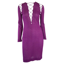
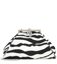
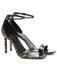
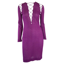
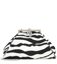
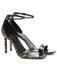
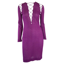
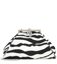
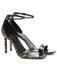
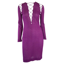
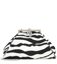
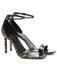

In [ ]:
# prepare training sample images
import os
import random

html_str = "<div style='display: flex;gap: 22px;flex-wrap: wrap;'>"

total_training_num = 3
x_query_sample = x_query[idx]
current_class = test_metadata[idx]['label']
other_class = 1
current_class_idxes = np.where(y_observed==current_class)[0]
# other_class_idxes = np.where(y_observed!=current_class)[0] #use all other brands as negative
other_class_idxes = np.where(y_observed==other_class)[0] #fix certain brand as negative

##set the training data-------1
# random_indx = random.randint(1, 100)
random_indx = 34
alpha_eps = 4
print(f"random image in pos/neg is:{random_indx}")

##set the training data-------1 
trainning_class_idxes = [current_class_idxes[random_indx]]
# np.random.shuffle(trainning_class_idxes)
trainning_y = y_observed[trainning_class_idxes]
trainning_x = x_observed[trainning_class_idxes]
trainning_y_current = np.zeros(trainning_y.shape)
trainning_y_current[np.where(trainning_y==current_class)]=1
output = probabilistic_probe.gpp(np.expand_dims(x_query[idx],axis=0), None, None) #alpha_eps=1 
print(f"Episteme (prior):{100*output['Episteme'][0]:0.2f}%")
print(f"Judged probability:{100*output['Judged probability'][0]:0.2f}%")
print(f"Alea:{100*output['Alea'][0]:0.2f}%")
output = probabilistic_probe.gpp(np.expand_dims(x_query[idx],axis=0), trainning_x, trainning_y_current,alpha_eps=alpha_eps ) #alpha_eps=1 

html_str = prepare_img_div(idx,html_str)

##set the training data-------1 0 
trainning_class_idxes = [current_class_idxes[random_indx], other_class_idxes[random_indx]]
trainning_y = y_observed[trainning_class_idxes]
trainning_x = x_observed[trainning_class_idxes]
trainning_y_current = np.zeros(trainning_y.shape)
trainning_y_current[np.where(trainning_y==current_class)]=1
output = probabilistic_probe.gpp(np.expand_dims(x_query[idx],axis=0), trainning_x, trainning_y_current,alpha_eps=alpha_eps ) #alpha_eps=1 
html_str = prepare_img_div(idx,html_str)

##set the training data-------1 0 1
trainning_class_idxes = [current_class_idxes[random_indx], other_class_idxes[random_indx], current_class_idxes[random_indx+1]]
trainning_y = y_observed[trainning_class_idxes]
trainning_x = x_observed[trainning_class_idxes]
trainning_y_current = np.zeros(trainning_y.shape)
trainning_y_current[np.where(trainning_y==current_class)]=1
output = probabilistic_probe.gpp(np.expand_dims(x_query[idx],axis=0), trainning_x, trainning_y_current,alpha_eps=alpha_eps ) #alpha_eps=1 
html_str = prepare_img_div(idx,html_str)
                                                                                   
##set the training data-------1 0 0(actual is 1)
trainning_class_idxes = [current_class_idxes[random_indx], other_class_idxes[random_indx], current_class_idxes[random_indx+1]]
trainning_y = y_observed[trainning_class_idxes]
trainning_x = x_observed[trainning_class_idxes]
trainning_y_current = np.zeros(trainning_y.shape)
trainning_y_current[np.where(trainning_y==current_class)]=1
## fake the label
trainning_y_current[2]=0
output = probabilistic_probe.gpp(np.expand_dims(x_query[idx],axis=0), trainning_x, trainning_y_current,alpha_eps=alpha_eps) #alpha_eps=1 
html_str = prepare_img_div(idx,html_str)

html_str += '</div>'
ipd.HTML(html_str)

